# ETRA Challenge Report

# Setup

In [150]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import missingno as msno
import pymc as pm

# classes for special types
from pandas.api.types import CategoricalDtype
from scipy.sparse._data import _data_matrix

# Apply the default theme
sns.set_theme()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [35]:
# @formatter:off
%matplotlib inline
# should enable plotting without explicit call .show()

%load_ext pretty_jupyter
#@formatter:on

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


## Downloading data

Download zip file from the web page. Description of the dataset is on the page [ETRA dataset description](https://etra.acm.org/2019/challenge.html)

In [36]:
from etra import ETRA

dataset = ETRA()

Dataset etra already downloaded.
Unpacking etra...


The directory ``data`` should therefore contain following directories/files

- data
- images
- DataSummary.csv

## Load Data

In [37]:
from etra import read_data

subject_no = 22
fix_puzzle_files = (dataset.data_dir / "data" / "{0:0>3}".format(subject_no)).glob("*Fixation_Puzzle_*.csv")
df_fix_puzzle = pd.concat((read_data(f) for f in fix_puzzle_files)).sort_values(by="Time")

fix_waldo_files = (dataset.data_dir / "data" / "{0:0>3}".format(subject_no)).glob("*Fixation_Waldo_*.csv")
df_fix_waldo = pd.concat((read_data(f) for f in fix_waldo_files)).sort_values(by="Time")

free_puzzle_files = (dataset.data_dir / "data" / "{0:0>3}".format(subject_no)).glob("*FreeViewing_Puzzle_*.csv")
df_free_puzzle = pd.concat((read_data(f) for f in free_puzzle_files)).sort_values(by="Time")

free_natural_files = (dataset.data_dir / "data" / "{0:0>3}".format(subject_no)).glob("*FreeViewing_Natural_*.csv")
df_free_natural = pd.concat((read_data(f) for f in free_natural_files)).sort_values(by="Time")

In [38]:
df_fix_puzzle.head()

,participant_id,trial_id,fv_fixation,task_type,stimulus_id,Time,LXpix,LYpix,RXpix,RYpix,LXhref,LYhref,RXhref,RYhref,LP,RP
0,022,005,Fixation,Puzzle,puz010,588684,457.94,311.400,458.98,311.175,151.0,3472.0,162.0,3470.0,422,517
1,022,005,Fixation,Puzzle,puz010,588686,457.30,311.775,459.62,311.325,145.0,3476.0,169.0,3471.0,420,519
2,022,005,Fixation,Puzzle,puz010,588688,456.74,312.150,460.34,311.475,139.0,3480.0,177.0,3472.0,419,521
3,022,005,Fixation,Puzzle,puz010,588690,455.70,309.150,459.70,310.800,128.0,3448.0,170.0,3466.0,427,520
4,022,005,Fixation,Puzzle,puz010,588692,456.98,311.400,461.38,310.350,142.0,3472.0,187.0,3460.0,425,526


In [39]:
df_fix_waldo.head()

,participant_id,trial_id,fv_fixation,task_type,stimulus_id,Time,LXpix,LYpix,RXpix,RYpix,LXhref,LYhref,RXhref,RYhref,LP,RP
0,022,004,Fixation,Waldo,wal007,539514,462.66,318.750,461.30,314.400,135.0,3560.0,121.0,3513.0,514,607
1,022,004,Fixation,Waldo,wal007,539516,459.38,317.400,457.70,313.800,138.0,3563.0,121.0,3524.0,514,609
2,022,004,Fixation,Waldo,wal007,539518,458.34,316.650,458.66,312.900,127.0,3555.0,131.0,3514.0,516,610
3,022,004,Fixation,Waldo,wal007,539520,459.38,317.175,457.70,314.475,138.0,3561.0,121.0,3531.0,515,617
4,022,004,Fixation,Waldo,wal007,539522,458.66,318.450,458.66,312.825,130.0,3575.0,131.0,3512.0,517,613


## Hypotheses



We will be interested in the following hypotheses:

1. **Is there a point where a participant becomes tired/bored when viewing a scene? (the frequency of saccades decreases) If so, are some scenes less interesting then others?**
    
    There are different types of scenes in the study and some are more visually stimulating then others. For example, it is not unreasonable to expect that a participant will stay much more engaged in a scene with a lot of detail to study then when looking at a blank scene. Another possibility is that during visual searches (picture puzzles, where is Waldo) a participant may become frustrated and just give up on the task. 

    The reasoning behind the way we are going to measure this is as follows. When a participant is engaged in a scene, we assume that their gaze is going to dart across the scene rapidly, as they are studying all the details and the number of saccades during a fixed time frame is going to be very high. On the other hand, when subject becomes bored or frustrated, we might expect that they are going to rest their gaze at some point and not move their eyes very much (maybe just expecting for the experiment to be over) and so the frequency of saccades is going to decrease.

    However, the decrease in frequency of saccades might not be exactly indicative of the subjects boredom or frustration. It is not unlikely that the frequency of saccades is high every time a new scene is introduced and naturally decreases as the subject becomes acquainted with the scene.

    Whatever the reason might be, if there indeed is such a changing point in the frequency of saccades, it might be interesting to study the time for such change and it's relationship to participant, scene and task.


2. **Does the pupil size change depending on scene? What about dependence on task?**

    The motivation behind this hypothesis is that we would like to study the excitement of a subject viewing some scene or performing some task. One of the indicators of excitement might be the change in pupil size (i.e. we expect pupil to dilate during excitement and contract otherwise).

    There are various tasks and scenes and the level of excitement (pupil dilation) might differ in each:
    - in **picture puzzles** we might expect that the level of excitement is kept high during the whole duration, peaking when subject finds a difference
    - in _**Where is Waldo?**_ puzzle we might expect the level of excitement being low as the subject is having difficulties finding Waldo and peaking when (if) Waldo is found
    - viewing a **blank scene** might not excite much

    Therefore, it is interesting to ask which tasks and scenes are the most stimulating and whether any significant distinction can be made.

## Data manipulation

This is an optional section, in which you could describe, what did you do with the data to obtain given format. In our example, we just need to merge the data. Additionally, we want to detect fixations

In [40]:
from etra import detect

df_hyp1_samples = df_free_natural.rename({"Time": "time", "trial_id": "trial", "LXpix": "x", "LYpix": "y"}, axis=1)
df_hyp1_samples["time"] = df_hyp1_samples.groupby(["participant_id", "trial"])["time"].transform(lambda x: x - x.min())

df_hyp1_sacc = []
groups = df_hyp1_samples.groupby(["participant_id", "trial"])
for (pid, trial), group in groups:
    tmp = detect(group)
    tmp = tmp[tmp["label"] == "SACC"]
    tmp["participant_id"] = pid
    tmp["trial"] = trial
    df_hyp1_sacc.append(tmp)

df_hyp1_sacc = pd.concat(df_hyp1_sacc)
df_hyp1_sacc = df_hyp1_samples[
    ["participant_id", "trial", "fv_fixation", "task_type", "stimulus_id"]].drop_duplicates().merge(df_hyp1_sacc, on=[
    "participant_id", "trial"], how="left")

Computed velocity exceeds threshold. Inappropriate filter setup? [1569.3 > 1500.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1692.4 > 1500.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1525.3 > 1500.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2035.5 > 1500.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2214.0 > 1500.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2018.2 > 1500.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1616.7 > 1500.0 deg/s]


In [41]:
df_hyp1_sacc

,participant_id,trial,fv_fixation,task_type,stimulus_id,label,start_time,end_time,start_x,start_y,end_x,end_y,amp,peak_vel,med_vel,avg_vel
0,022,003,FreeViewing,Natural,nat010,SACC,258,308,462.939827,315.148377,299.453766,278.508442,6.326922,254.231181,141.080614,141.445507
1,022,003,FreeViewing,Natural,nat010,SACC,480,526,289.379654,275.827922,591.837143,217.017532,11.635705,409.015620,285.235234,254.767241
2,022,003,FreeViewing,Natural,nat010,SACC,670,724,575.267446,219.270130,253.125108,178.131818,12.263950,413.862127,285.146338,238.429579
3,022,003,FreeViewing,Natural,nat010,SACC,1166,1194,169.417056,157.048701,175.081818,290.109091,5.029351,584.710677,94.861205,207.182861
4,022,003,FreeViewing,Natural,nat010,SACC,1266,1300,174.783636,285.601948,155.359221,121.611364,6.236117,351.750150,174.715939,188.218606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,022,120,FreeViewing,Natural,nat005,SACC,43566,43824,346.139481,572.417208,747.106753,604.495455,15.190226,1485.930097,0.000000,81.346614
1348,022,120,FreeViewing,Natural,nat005,SACC,43908,43960,649.730476,570.438636,820.874372,568.003571,6.463612,289.197078,121.548295,132.622047
1349,022,120,FreeViewing,Natural,nat005,SACC,44192,44224,816.331688,569.631494,729.898442,558.972727,3.288729,222.459337,84.917971,104.677499
1350,022,120,FreeViewing,Natural,nat005,SACC,44392,44424,732.376364,559.287662,610.189697,565.907792,4.620939,238.402342,164.946265,146.341177


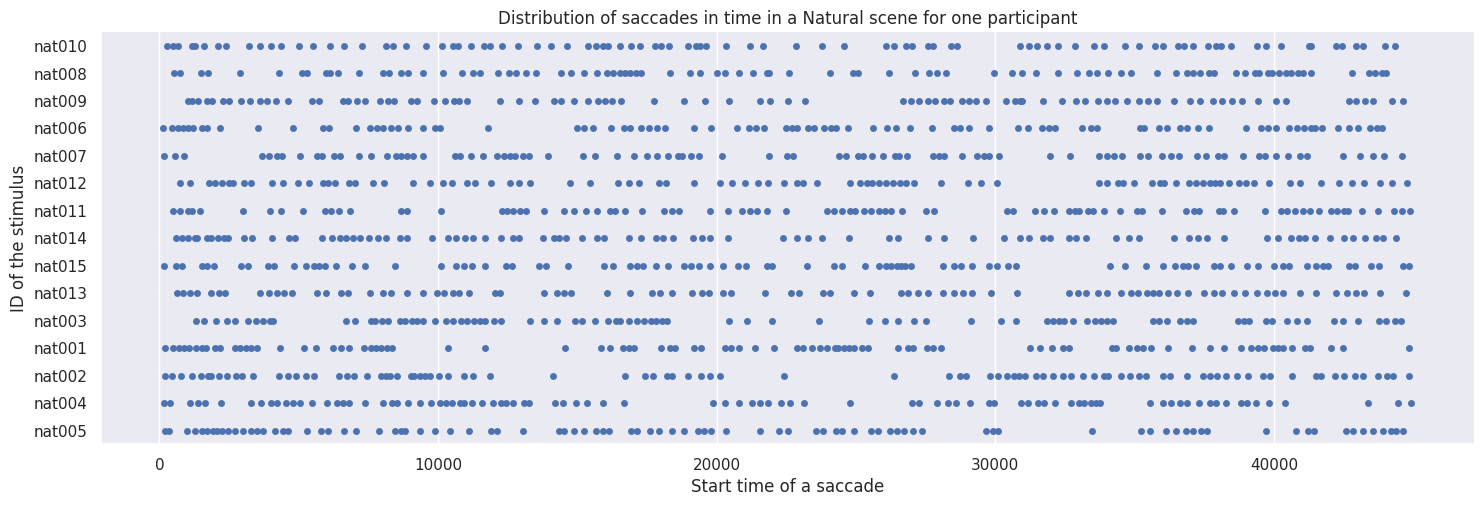

In [45]:
# Plot the distriution of saccades in time
g = sns.catplot(
    data=df_hyp1_sacc,
    x='start_time',
    y='stimulus_id',
    jitter=False,
    aspect=3,
)
g.set_xlabels("Start time of a saccade")
g.set_ylabels("ID of the stimulus")
g.set(title="Distribution of saccades in time in a Natural scene for one participant")

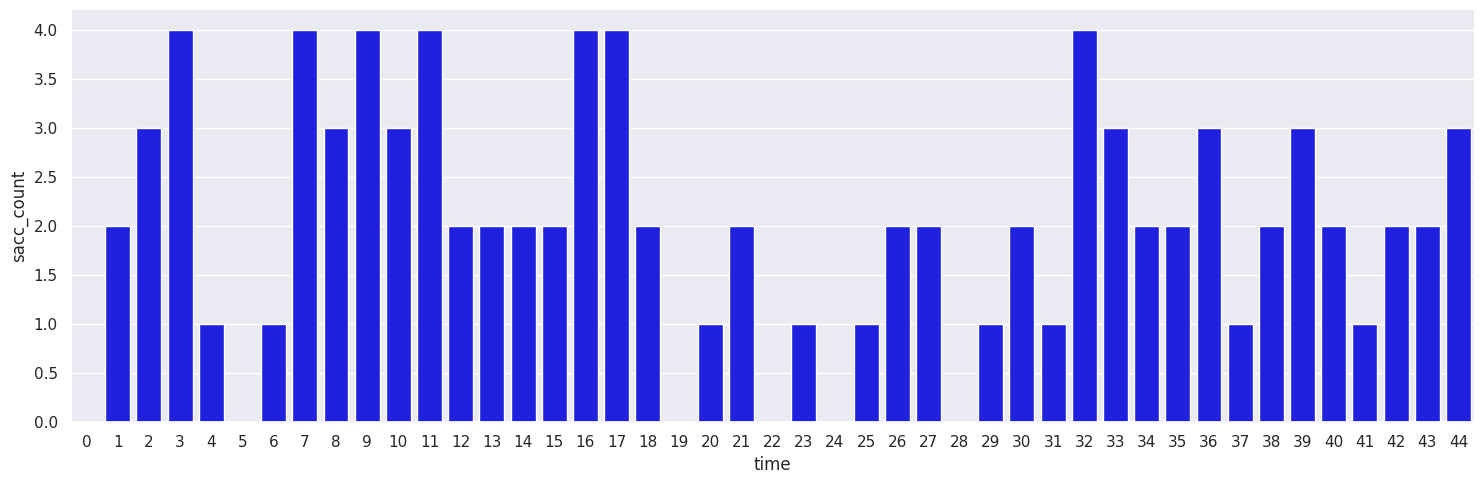

In [142]:
# Count the number of saccades each second
def saccade_frequency_count_by_second(data):
    bins = (data.start_time // 1000).value_counts().sort_index()
    data = pd.DataFrame({"time": range(45)})
    data["sacc_count"] = bins
    data.fillna(0, inplace=True)
    data.sacc_count = data.sacc_count.astype(int)
    
    return data

counts = saccade_frequency_count_by_second(df_hyp1_sacc[df_hyp1_sacc.stimulus_id == "nat003"])
sns.catplot(data=counts, x='time', y='sacc_count', kind="bar", color="blue", aspect=3)

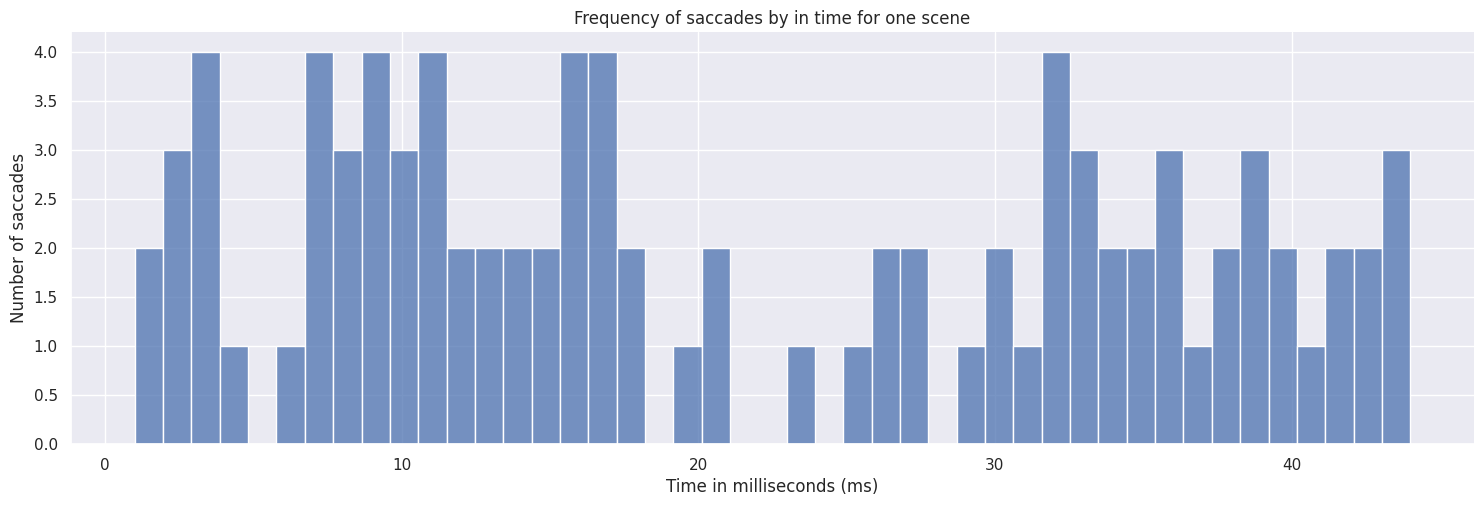

In [149]:
scene = df_hyp1_sacc[df_hyp1_sacc.stimulus_id == "nat003"].copy()
scene.start_time = scene.start_time.apply(lambda ms: ms // 1000)

g = sns.displot(data=scene, x='start_time', bins=45, stat="count", aspect=3)
g.set_xlabels("Time in milliseconds (ms)")
g.set_ylabels("Number of saccades")
g.set(title="Frequency of saccades by in time for one scene")

In [164]:
count_data = saccade_frequency_count_by_second(df_hyp1_sacc[df_hyp1_sacc.stimulus_id == "nat003"])
count_data = count_data.sacc_count
n_count_data = count_data.shape[0]

In [166]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

    index = np.arange(n_count_data)
    lambda_ = pm.math.switch( tau >= index, lambda_1, lambda_2 )
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [167]:
with model:
    pm.sample(5000)

We model the start times of saccades as a Poisson process.

## Results

In this section, describe statistical test that you used for testing your hypotheses. In general, the selection of statistical test depends on the type of variable.

There are following types of variables:

* Continuous - when the variable behaves as number. All fixation durations, pupil size, time are continuous variables
* Ordinal - variables do not behave as numbers, but you can order them. Grades in school are typical example. You can't say how many times is 1 better than 2, but you can say that 1 is better grade than 2. There are no nominal variables in this dataset, so I added this description only for completeness.
* Nominal - when variables are qualitative different. Type of task is an example of nominal variable

In the case of two variables, there are following options
* both variables continuous - regression or correlation (in R function `lm()` or `cor`/`cor.test` )
* both variables nominal - contingency tables a chi square test
* one variable nominal, other continuous - this is very common, this type is used, when we compare differences two condition - in this case, we use t.tests

There are three main types of t.tests

* Independent t-test - both groups contain independent data points (each data point is a different entity)
* Paired t-test - data points are linked to each other. This is typical example, when we measure same subjects multiple times
* One sample t-test - we are testing the sample against some theoretically interesting number

In case of more than two variables, we need to use ANOVAs. Usually, one variable will be dependent (outcome, the one which levels interest us) and others will be independent (predictors, the one, that we manipulate).
* For more than two groups, we use between-subject ANOVA
* For more than two measurement of same subject, we use within-subject ANOVA
* We can combine multiple between- and within-subject factors into mixed ANOVA

In our case, the simplest way how to test that is to aggregate data per each trial and use t-tests

### using t-tests

Because we have multiple data points from each participant, we can first aggregate data for each trial

In [44]:
avg_durations = df_hyp1_fix.assign(dur=lambda x: x.end_time - x.start_time)\
    .groupby(["task_type", "trial"])\
    .agg(avg_dur=("dur", "mean"))\
    .reset_index()
avg_durations

NameError: name 'df_hyp1_fix' is not defined

In [ ]:
ttest_result = stats.ttest_rel(
    avg_durations[avg_durations.task_type == "Puzzle"].avg_dur,
    avg_durations[avg_durations.task_type == "Waldo"].avg_dur,
)

: 

In [ ]:
%%jinja markdown

Results show that there is no difference between Fixation duration in Where is Waldo and Puzzle (pvalue={{"{:.3}".format(ttest_result.pvalue)}})

: 